# DD/PD Analysis: Visualizations, Statistics, and Outlier Detection

This notebook provides comprehensive analysis of Distance-to-Default (DD) and Probability-of-Default (PD) metrics:

1. **Data Loading**: Load latest merged dataset
2. **Descriptive Statistics**: Summary stats and distributions
3. **Visualizations**: Distributions, time series, scatter plots
4. **Correlation Analysis**: Correlation matrices and heatmaps
5. **Regression Analysis**: OLS regressions
6. **2SLS Analysis**: Two-stage least squares instrumental variable estimation
7. **Outlier Detection**: Identify and categorize outliers with archiving

In [1]:
# Setup and imports
from pathlib import Path
from datetime import datetime
import pytz
import shutil
import glob
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# Statistical modeling
from IPython.display import display
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.sandbox.regression.gmm import IV2SLS
from linearmodels.iv import IV2SLS as IV2SLS_alt

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Helper functions
def find_repo_root(start: Path, marker: str = '.git') -> Path:
    current = start.resolve()
    for candidate in [current, *current.parents]:
        if (candidate / marker).exists():
            return candidate
    return current

def get_timestamp_cdt():
    """Generate timestamp in YYYYMMDD_HHMMSS format (CDT timezone)"""
    cdt = pytz.timezone('America/Chicago')
    return datetime.now(cdt).strftime('%Y%m%d_%H%M%S')

def archive_old_files(output_dir, archive_dir, dataset_type, max_keep=5):
    """Move old files of dataset_type to archive, keeping only max_keep most recent"""
    pattern = str(output_dir / f"{dataset_type}_*.csv")
    old_files = sorted(glob.glob(pattern), key=lambda x: os.path.getmtime(x), reverse=True)
    
    for old_file in old_files:
        archive_path = archive_dir / os.path.basename(old_file)
        shutil.move(old_file, str(archive_path))
        print(f"[ARCHIVE] {os.path.basename(old_file)}")
    
    archive_pattern = str(archive_dir / f"{dataset_type}_*.csv")
    archive_files = sorted(glob.glob(archive_pattern), key=lambda x: os.path.getmtime(x), reverse=True)
    
    for old_archive in archive_files[max_keep:]:
        os.remove(old_archive)
        print(f"[CLEANUP] {os.path.basename(old_archive)}")

def get_latest_file(output_dir, dataset_type):
    """Get the most recent file of given dataset_type"""
    pattern = str(output_dir / f"{dataset_type}_*.csv")
    files = sorted(glob.glob(pattern), key=lambda x: os.path.getmtime(x), reverse=True)
    if not files:
        raise FileNotFoundError(f"No {dataset_type} files found")
    return files[0]

# Setup paths
base_dir = find_repo_root(Path.cwd())
datasheet_dir = base_dir / 'data' / 'outputs' / 'datasheet'
analysis_dir = base_dir / 'data' / 'outputs' / 'analysis'
archive_dir = base_dir / 'archive' / 'datasets'

analysis_dir.mkdir(parents=True, exist_ok=True)
archive_dir.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {base_dir}")
print(f"Analysis output: {analysis_dir}")

Base directory: /Users/guillaumebld/Documents/Graduate_Research/Professor Abol Jalilvand/fall2025/risk_bank/risk_bank
Analysis output: /Users/guillaumebld/Documents/Graduate_Research/Professor Abol Jalilvand/fall2025/risk_bank/risk_bank/data/outputs/analysis


## 1. Data Loading

In [3]:
# Load latest merged dataset
merged_file = get_latest_file(datasheet_dir, 'merged')
print(f"Loading: {os.path.basename(merged_file)}")

df = pd.read_csv(merged_file)
print(f"\nDataset: {len(df)} rows, {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns[:20])}..." if len(df.columns) > 20 else f"\nColumns: {list(df.columns)}")

# Show sample

# Guard rails: Clean PD and DD values
# Ensure PD in [0,1]
for c in ['PD_a', 'PD_m']:
    if c in df.columns:
        df.loc[~df[c].between(0, 1), c] = np.nan

# Trim extreme DD for stability
for c in ['DD_a', 'DD_m']:
    if c in df.columns:
        q01, q99 = df[c].quantile([0.01, 0.99])
        df[c] = df[c].clip(q01, q99)

display(df[['instrument', 'year', 'DD_a', 'PD_a', 'DD_m', 'PD_m']].head(10))

# Column aliases for backwards compatibility
alias = {
    'DD_naive': 'DD_a', 'PD_naive': 'PD_a',
}
for old, new in alias.items():
    if old in df.columns and new not in df.columns:
        df[new] = df[old]


Loading: merged_20251004_051328.csv

Dataset: 1425 rows, 73 columns

Columns: ['instrument', 'year', 'a_E', 'a_E_source', 'a_weak_E_proxy', 'a_E_pb', 'a_E_de', 'a_E_wacc', 'a_F', 'a_sigma_E', 'a_sigma_D_hat', 'a_sigma_V_hat', 'a_mu_hat', 'DD_a', 'PD_a', 'a_naive_status', 'm_covid', 'm_rit_rf', 'm_rit', 'm_new_wacc']...


,instrument,year,DD_a,PD_a,DD_m,PD_m
0,ABCB,2016,17.191718,1.531595e-66,NaN,NaN
1,ABCB,2017,22.140950,6.375977e-109,NaN,NaN
2,ABCB,2018,46.873017,0.000000e+00,28.963232,9.560799e-185
3,ABCB,2019,6.049042,7.285482e-10,4.133342,1.787627e-05
4,ABCB,2020,12.092687,5.772411e-34,6.880048,2.991617e-12
5,ABCB,2021,16.945177,1.044526e-64,10.279523,4.357884e-25
6,ABCB,2022,13.409921,2.644752e-41,7.278021,1.693760e-13
7,ABCB,2023,17.757759,7.505416e-71,10.586485,1.721396e-26
8,ACNB,2019,17.095048,8.078189e-66,NaN,NaN
9,ACNB,2020,16.942326,1.096400e-64,NaN,NaN


## 2. Descriptive Statistics

In [4]:
# Summary statistics for DD and PD
print("=== DISTANCE TO DEFAULT (DD) STATISTICS ===")
print("\nAccounting DD (DD_a):")
print(df['DD_a'].describe())

print("\nMarket DD (DD_m):")
print(df['DD_m'].describe())

print("\n=== PROBABILITY OF DEFAULT (PD) STATISTICS ===")
print("\nAccounting PD (PD_a):")
print(df['PD_a'].describe())

print("\nMarket PD (PD_m):")
print(df['PD_m'].describe())

# Coverage statistics
print("\n=== DATA COVERAGE ===")
print(f"Observations with both DD_a and DD_m: {df[['DD_a', 'DD_m']].dropna().shape[0]}")
print(f"Observations with only DD_a: {df['DD_a'].notna().sum() - df[['DD_a', 'DD_m']].dropna().shape[0]}")
print(f"Observations with only DD_m: {df['DD_m'].notna().sum() - df[['DD_a', 'DD_m']].dropna().shape[0]}")
print(f"Total unique instruments: {df['instrument'].nunique()}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")

=== DISTANCE TO DEFAULT (DD) STATISTICS ===

Accounting DD (DD_a):
count    1409.000000
mean       20.078672
std        13.059201
min         5.300856
25%        12.242458
50%        16.616343
75%        22.917770
max        81.378024
Name: DD_a, dtype: float64

Market DD (DD_m):
count    930.000000
mean      12.203202
std        8.026385
min        3.082938
25%        6.439077
50%        9.538566
75%       15.106819
max       35.000000
Name: DD_m, dtype: float64

=== PROBABILITY OF DEFAULT (PD) STATISTICS ===

Accounting PD (PD_a):
count     1.409000e+03
mean      7.469649e-04
std       2.667248e-02
min       0.000000e+00
25%      1.545023e-116
50%       2.653631e-62
75%       9.218141e-35
max       9.998768e-01
Name: PD_a, dtype: float64

Market PD (PD_m):
count     9.300000e+02
mean      8.217333e-05
std       1.093972e-03
min      1.124911e-268
25%       7.685700e-52
50%       7.245797e-22
75%       6.013341e-11
max       2.577147e-02
Name: PD_m, dtype: float64

=== DATA COVERAGE =

## 3. Visualizations

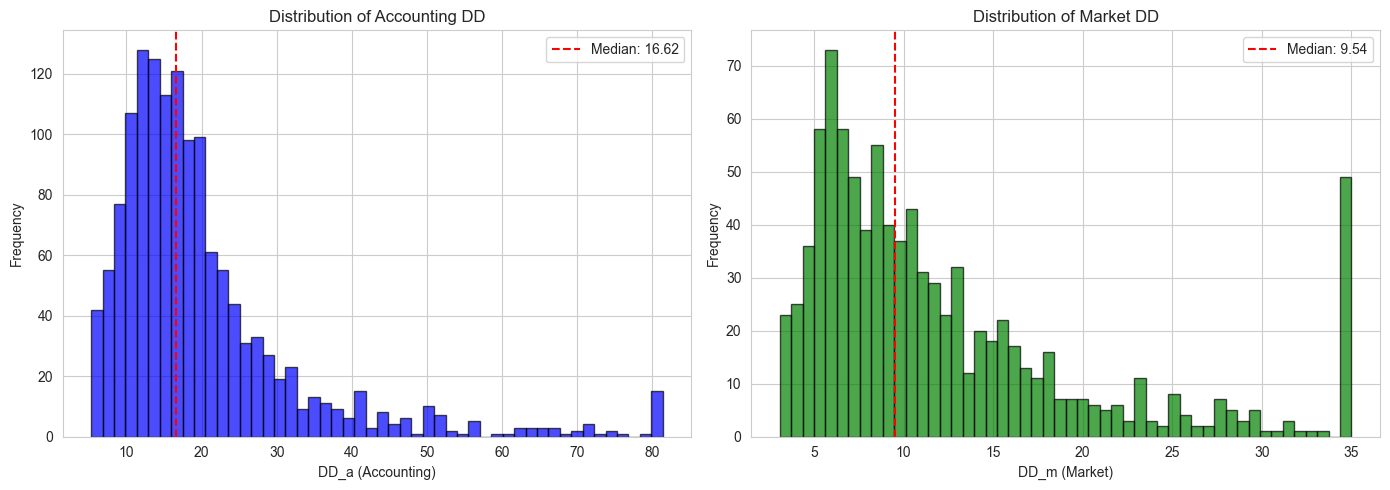

In [5]:
# Distribution plots for DD
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DD_a distribution
axes[0].hist(df['DD_a'].dropna(), bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(df['DD_a'].median(), color='red', linestyle='--', label=f'Median: {df["DD_a"].median():.2f}')
axes[0].set_xlabel('DD_a (Accounting)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Accounting DD')
axes[0].legend()

# DD_m distribution
axes[1].hist(df['DD_m'].dropna(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(df['DD_m'].median(), color='red', linestyle='--', label=f'Median: {df["DD_m"].median():.2f}')
axes[1].set_xlabel('DD_m (Market)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Market DD')
axes[1].legend()

plt.tight_layout()
plt.show()

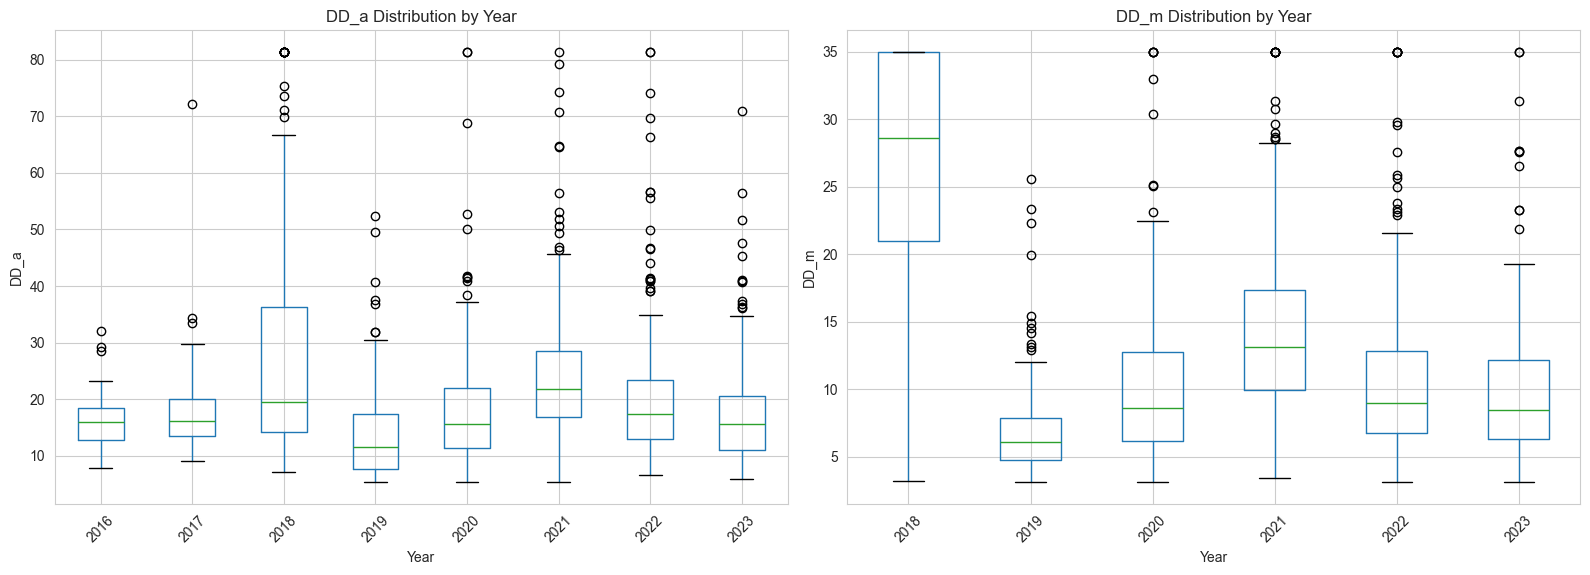

In [6]:
# Box plots by year
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# DD_a by year
df_plot_a = df.dropna(subset=['DD_a', 'year']).copy()
if not df_plot_a.empty:
    df_plot_a['year'] = df_plot_a['year'].astype(str)
    df_plot_a.boxplot(column='DD_a', by='year', ax=axes[0])
    axes[0].set_title('DD_a Distribution by Year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('DD_a')
    plt.sca(axes[0])
    plt.xticks(rotation=45)

# DD_m by year
df_plot_m = df.dropna(subset=['DD_m', 'year']).copy()
if not df_plot_m.empty:
    df_plot_m['year'] = df_plot_m['year'].astype(str)
    df_plot_m.boxplot(column='DD_m', by='year', ax=axes[1])
    axes[1].set_title('DD_m Distribution by Year')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('DD_m')
    plt.sca(axes[1])
    plt.xticks(rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()

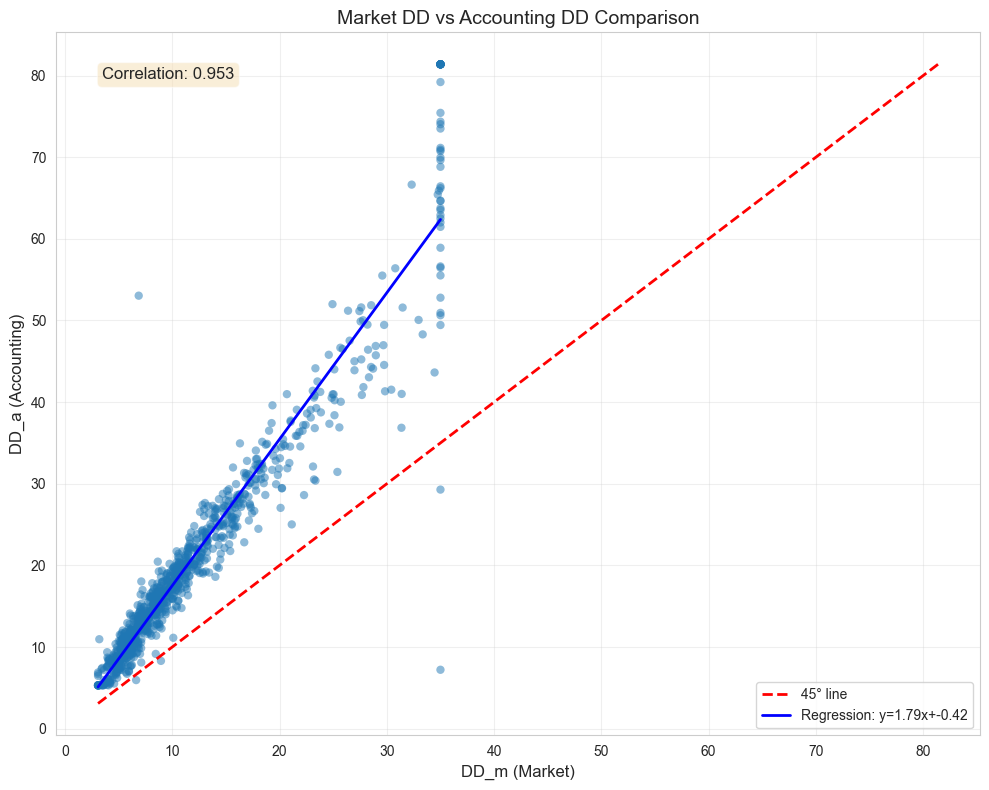

In [7]:
# Scatter plot: DD_m vs DD_a
merged_dd = df[['DD_a', 'DD_m']].dropna()

if not merged_dd.empty:
    merged_dd = merged_dd[np.isfinite(merged_dd['DD_m']) & np.isfinite(merged_dd['DD_a'])]
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(merged_dd['DD_m'], merged_dd['DD_a'], alpha=0.5, edgecolors='none')
    
    # 45-degree line
    all_vals = np.concatenate([merged_dd['DD_m'].to_numpy(), merged_dd['DD_a'].to_numpy()])
    lims = [all_vals.min(), all_vals.max()]
    ax.plot(lims, lims, linestyle='--', color='red', linewidth=2, label='45° line')
    
    # Regression line
    z = np.polyfit(merged_dd['DD_m'], merged_dd['DD_a'], 1)
    p = np.poly1d(z)
    ax.plot(merged_dd['DD_m'].sort_values(), p(merged_dd['DD_m'].sort_values()), 
            linestyle='-', color='blue', linewidth=2, label=f'Regression: y={z[0]:.2f}x+{z[1]:.2f}')
    
    ax.set_xlabel('DD_m (Market)', fontsize=12)
    ax.set_ylabel('DD_a (Accounting)', fontsize=12)
    ax.set_title('Market DD vs Accounting DD Comparison', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Calculate correlation
    corr = merged_dd['DD_m'].corr(merged_dd['DD_a'])
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
else:
    print("No overlapping DD_m/DD_a observations for scatter plot")

## 4. Correlation Analysis


Dummy variables created:
  size_dummy: 702 large banks, 723 small banks
  covid_dummy: 791 COVID-period obs, 634 pre-COVID obs

=== CORRELATION MATRIX ===
          DD_a      PD_a      DD_m      PD_m
DD_a  1.000000 -0.031713  0.953045 -0.077389
PD_a -0.031713  1.000000 -0.059412  0.221623
DD_m  0.953045 -0.059412  1.000000 -0.085208
PD_m -0.077389  0.221623 -0.085208  1.000000


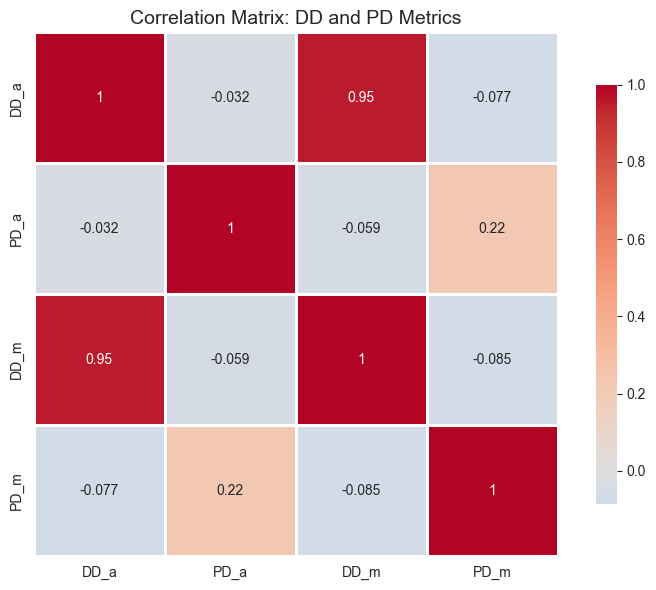

In [8]:
# Construct size and COVID dummies
# Size dummy: median split (handle NaN)
if 'a_total_assets' in df.columns:
    median_assets = df['a_total_assets'].median()
    df['size_dummy'] = (df['a_total_assets'] > median_assets).fillna(0).astype(int)
elif 'm_total_assets' in df.columns:
    median_assets = df['m_total_assets'].median()
    df['size_dummy'] = (df['m_total_assets'] > median_assets).fillna(0).astype(int)
else:
    print('[WARN] No total assets column found')

# COVID dummy: prefer existing column, else derive from year (handle NaN)
if 'a_covid' in df.columns:
    df['covid_dummy'] = df['a_covid'].fillna(0).astype(int)
elif 'm_covid' in df.columns:
    df['covid_dummy'] = df['m_covid'].fillna(0).astype(int)
elif 'covid' in df.columns:
    df['covid_dummy'] = df['covid'].fillna(0).astype(int)
elif 'year' in df.columns:
    df['covid_dummy'] = (df['year'] >= 2020).astype(int)
else:
    print('[WARN] No COVID proxy available')

print(f"\nDummy variables created:")
if 'size_dummy' in df.columns:
    print(f"  size_dummy: {df['size_dummy'].sum()} large banks, {(~df['size_dummy'].astype(bool)).sum()} small banks")
if 'covid_dummy' in df.columns:
    print(f"  covid_dummy: {df['covid_dummy'].sum()} COVID-period obs, {(~df['covid_dummy'].astype(bool)).sum()} pre-COVID obs")

# Correlation matrix for key variables
corr_vars = ['DD_a', 'PD_a', 'DD_m', 'PD_m']
# Filter to only columns that exist
corr_vars_available = [v for v in corr_vars if v in df.columns]
if len(corr_vars_available) >= 2:
    corr_matrix = df[corr_vars_available].corr()

    print("\n=== CORRELATION MATRIX ===")
    print(corr_matrix)

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix: DD and PD Metrics', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("[WARN] Insufficient variables for correlation matrix")

## 5. Regression Analysis

=== OLS REGRESSION: DD_a ~ DD_m ===
                            OLS Regression Results                            
Dep. Variable:                   DD_a   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     9191.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:19:05   Log-Likelihood:                -2733.2
No. Observations:                 930   AIC:                             5470.
Df Residuals:                     928   BIC:                             5480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0

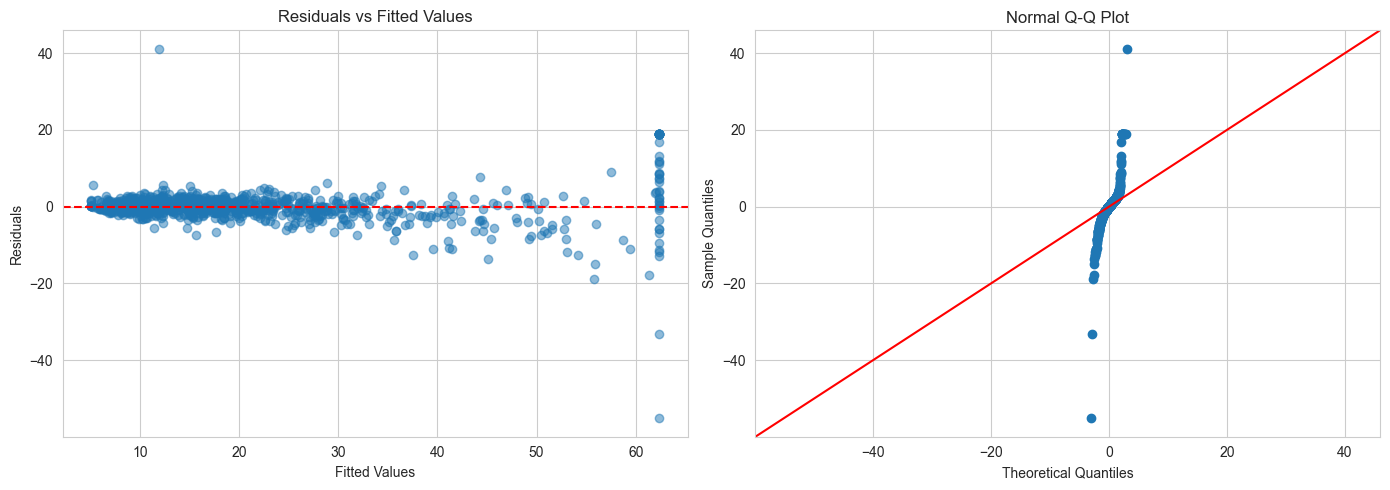

In [9]:
# OLS Regression: DD_a on DD_m
reg_data = df[['DD_a', 'DD_m']].dropna()

if len(reg_data) > 10:
    X = sm.add_constant(reg_data['DD_m'])
    y = reg_data['DD_a']
    
    model = OLS(y, X).fit()
    print("=== OLS REGRESSION: DD_a ~ DD_m ===")
    print(model.summary())
    
    # Residual plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Residuals vs fitted
    axes[0].scatter(model.fittedvalues, model.resid, alpha=0.5)
    axes[0].axhline(y=0, color='r', linestyle='--')
    axes[0].set_xlabel('Fitted Values')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Fitted Values')
    
    # Q-Q plot
    sm.qqplot(model.resid, line='45', ax=axes[1])
    axes[1].set_title('Normal Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
else:
    print("Insufficient data for regression analysis")

In [10]:
# OLS Regression with Year Fixed Effects
if {'DD_a','DD_m','year'}.issubset(df.columns):
    reg_data_fe = df[['DD_a','DD_m','year']].dropna()
else:
    print('[WARN] Missing DD_a, DD_m, or year for FE regression')
    reg_data_fe = pd.DataFrame()

if len(reg_data_fe) > 10:
    # Ensure numeric types
    reg_data_fe = reg_data_fe.copy()
    reg_data_fe['DD_a'] = pd.to_numeric(reg_data_fe['DD_a'], errors='coerce')
    reg_data_fe['DD_m'] = pd.to_numeric(reg_data_fe['DD_m'], errors='coerce')
    reg_data_fe['year'] = pd.to_numeric(reg_data_fe['year'], errors='coerce')
    reg_data_fe = reg_data_fe.dropna()
    
    print(f'[INFO] FE regression sample: {len(reg_data_fe)} observations')
    
    # Use formula API with robust SE
    fe_res = smf.ols('DD_a ~ DD_m + C(year)', data=reg_data_fe).fit(cov_type='HC1')
    print('\n=== OLS WITH YEAR FIXED EFFECTS (HC1) ===')
    print(fe_res.summary())


[INFO] FE regression sample: 930 observations

=== OLS WITH YEAR FIXED EFFECTS (HC1) ===
                            OLS Regression Results                            
Dep. Variable:                   DD_a   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     614.8
Date:                Wed, 08 Oct 2025   Prob (F-statistic):          2.57e-318
Time:                        08:19:05   Log-Likelihood:                -2707.1
No. Observations:                 930   AIC:                             5428.
Df Residuals:                     923   BIC:                             5462.
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

## 6. Two-Stage Least Squares (2SLS) Analysis

In [11]:
# 2SLS: Instrumental variable estimation using linearmodels
# Prepare data with lags
df_sorted = df.sort_values(['instrument', 'year'])
df_sorted['DD_m_lag'] = df_sorted.groupby('instrument')['DD_m'].shift(1)
df_sorted['DD_a_lag'] = df_sorted.groupby('instrument')['DD_a'].shift(1)

iv_data = df_sorted[['DD_a','DD_m','DD_m_lag','DD_a_lag']].dropna()

if len(iv_data) > 30:
    print('=== 2SLS ESTIMATION (robust) ===')
    print(f'Sample size: {len(iv_data)}')
    
    try:
        iv_res = IV2SLS_alt.from_formula('DD_a ~ 1 + [DD_m ~ DD_m_lag + DD_a_lag]', data=iv_data).fit(cov_type='robust')
        print(iv_res.summary)
    except Exception as e:
        print(f'[ERROR] 2SLS estimation failed: {e}')
else:
    print('[WARN] Insufficient data for 2SLS (need >30 observations)')


=== 2SLS ESTIMATION (robust) ===
Sample size: 708
                          IV-2SLS Estimation Summary                          
Dep. Variable:                   DD_a   R-squared:                      0.8908
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8907
No. Observations:                 708   F-statistic:                    259.44
Date:                Wed, Oct 08 2025   P-value (F-stat)                0.0000
Time:                        08:19:05   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      1.8571     0.9829     1.8895     0.0588     -0.0693      3.7835
DD

## 7. Outlier Detection and Analysis

In [12]:
# Outlier detection functions (adapted from generate_outlier_doc.py)
OUTLIER_THRESHOLD = 13.0

def is_outlier_dd(value, threshold=OUTLIER_THRESHOLD):
    return pd.notna(value) and value > threshold

def categorize_outlier(row, dd_col, dataset_type):
    """Categorize outlier based on data characteristics"""
    if not is_outlier_dd(row[dd_col]):
        return None
    
    # Check for data quality issues
    prefix = 'a_' if dataset_type == 'accounting' else 'm_'
    
    # Zero-cost debt
    wacc_cost_col = f'{prefix}wacc_cost_of_debt,_(%)' if f'{prefix}wacc_cost_of_debt,_(%)' in row.index else None
    wacc_weight_col = f'{prefix}wacc_debt_weight,_(%)' if f'{prefix}wacc_debt_weight,_(%)' in row.index else None
    
    if wacc_cost_col and wacc_weight_col:
        if pd.notna(row[wacc_cost_col]) and pd.notna(row[wacc_weight_col]):
            if abs(row[wacc_cost_col]) < 1e-6 and abs(row[wacc_weight_col]) < 1e-6:
                return 'zero_cost_debt'
    
    # Low debt
    debt_col = f'{prefix}debt_total' if f'{prefix}debt_total' in row.index else None
    if debt_col and pd.notna(row[debt_col]) and row[debt_col] <= 1.0:
        return 'low_debt'
    
    # Low leverage
    de_col = f'{prefix}d/e' if f'{prefix}d/e' in row.index else None
    if de_col and pd.notna(row[de_col]) and row[de_col] <= 0.05:
        return 'low_leverage'
    
    return 'other'

# Identify outliers
df['outlier_a'] = df.apply(lambda row: categorize_outlier(row, 'DD_a', 'accounting'), axis=1)
df['outlier_m'] = df.apply(lambda row: categorize_outlier(row, 'DD_m', 'market'), axis=1)

# Summary
print("=== OUTLIER SUMMARY ===")
print(f"\nAccounting DD outliers (>{OUTLIER_THRESHOLD}): {df['outlier_a'].notna().sum()}")
if df['outlier_a'].notna().sum() > 0:
    print(df['outlier_a'].value_counts())

print(f"\nMarket DD outliers (>{OUTLIER_THRESHOLD}): {df['outlier_m'].notna().sum()}")
if df['outlier_m'].notna().sum() > 0:
    print(df['outlier_m'].value_counts())

=== OUTLIER SUMMARY ===

Accounting DD outliers (>13.0): 994
outlier_a
other    994
Name: count, dtype: int64

Market DD outliers (>13.0): 295
outlier_m
other             221
low_leverage       52
zero_cost_debt     19
low_debt            3
Name: count, dtype: int64


In [13]:
# Export outliers to CSV with archiving
timestamp = get_timestamp_cdt()

# Accounting outliers
outliers_a = df[df['outlier_a'].notna()].copy()
if len(outliers_a) > 0:
    archive_old_files(analysis_dir, archive_dir, 'outliers_accounting', max_keep=5)
    outliers_a_file = analysis_dir / f'outliers_accounting_{timestamp}.csv'
    outliers_a.to_csv(outliers_a_file, index=False)
    print(f"\n[SAVED] Accounting outliers: {outliers_a_file.name} ({len(outliers_a)} rows)")

# Market outliers
outliers_m = df[df['outlier_m'].notna()].copy()
if len(outliers_m) > 0:
    archive_old_files(analysis_dir, archive_dir, 'outliers_market', max_keep=5)
    outliers_m_file = analysis_dir / f'outliers_market_{timestamp}.csv'
    outliers_m.to_csv(outliers_m_file, index=False)
    print(f"[SAVED] Market outliers: {outliers_m_file.name} ({len(outliers_m)} rows)")

# Save sample sizes summary
sizes = {
    'n_all': len(df),
    'n_DDa': df['DD_a'].notna().sum() if 'DD_a' in df.columns else 0,
    'n_DDm': df['DD_m'].notna().sum() if 'DD_m' in df.columns else 0,
    'n_both': df[['DD_a','DD_m']].dropna().shape[0] if {'DD_a','DD_m'}.issubset(df.columns) else 0,
}
sizes_file = analysis_dir / f'sample_sizes_{timestamp}.csv'
pd.Series(sizes).to_csv(sizes_file, header=False)
print(f'\n[SAVED] Sample sizes: {sizes_file.name}')
print(f'  Total: {sizes["n_all"]}, DD_a: {sizes["n_DDa"]}, DD_m: {sizes["n_DDm"]}, Both: {sizes["n_both"]}')



[SAVED] Accounting outliers: outliers_accounting_20251008_081905.csv (994 rows)
[SAVED] Market outliers: outliers_market_20251008_081905.csv (295 rows)

[SAVED] Sample sizes: sample_sizes_20251008_081905.csv
  Total: 1425, DD_a: 1409, DD_m: 930, Both: 930


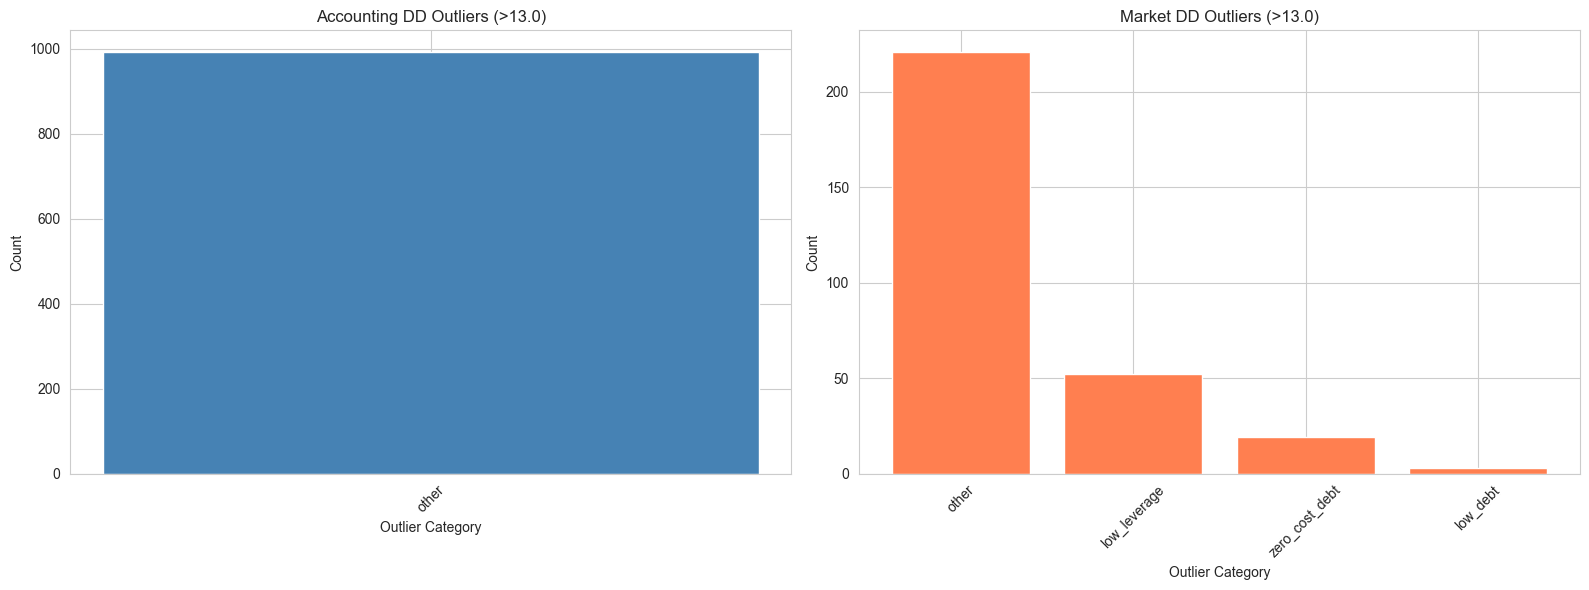

In [14]:
# Visualize outliers
if len(outliers_a) > 0 or len(outliers_m) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Accounting outliers
    if len(outliers_a) > 0:
        outlier_counts_a = outliers_a['outlier_a'].value_counts()
        axes[0].bar(outlier_counts_a.index, outlier_counts_a.values, color='steelblue')
        axes[0].set_xlabel('Outlier Category')
        axes[0].set_ylabel('Count')
        axes[0].set_title(f'Accounting DD Outliers (>{OUTLIER_THRESHOLD})')
        axes[0].tick_params(axis='x', rotation=45)
    
    # Market outliers
    if len(outliers_m) > 0:
        outlier_counts_m = outliers_m['outlier_m'].value_counts()
        axes[1].bar(outlier_counts_m.index, outlier_counts_m.values, color='coral')
        axes[1].set_xlabel('Outlier Category')
        axes[1].set_ylabel('Count')
        axes[1].set_title(f'Market DD Outliers (>{OUTLIER_THRESHOLD})')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

In [15]:
# Display sample outliers
if len(outliers_a) > 0:
    print("\n=== SAMPLE ACCOUNTING OUTLIERS ===")
    display(outliers_a[['instrument', 'year', 'DD_a', 'PD_a', 'outlier_a']].head(10))

if len(outliers_m) > 0:
    print("\n=== SAMPLE MARKET OUTLIERS ===")
    display(outliers_m[['instrument', 'year', 'DD_m', 'PD_m', 'outlier_m']].head(10))


=== SAMPLE ACCOUNTING OUTLIERS ===


,instrument,year,DD_a,PD_a,outlier_a
0,ABCB,2016,17.191718,1.531595e-66,other
1,ABCB,2017,22.140950,6.375977e-109,other
2,ABCB,2018,46.873017,0.000000e+00,other
5,ABCB,2021,16.945177,1.044526e-64,other
6,ABCB,2022,13.409921,2.644752e-41,other
7,ABCB,2023,17.757759,7.505416e-71,other
8,ACNB,2019,17.095048,8.078189e-66,other
9,ACNB,2020,16.942326,1.096400e-64,other
10,ACNB,2021,17.300053,2.349791e-67,other
11,ACNB,2022,18.138074,7.976185e-74,other



=== SAMPLE MARKET OUTLIERS ===


,instrument,year,DD_m,PD_m,outlier_m
2,ABCB,2018,28.963232,9.560799e-185,other
15,ALRS,2022,24.948390,1.111518e-137,other
16,ALRS,2023,23.284520,3.181069e-120,other
24,AROW,2020,15.119809,5.994508e-52,other
25,AROW,2021,17.295604,2.538386e-67,low_leverage
29,ASB,2018,14.762455,1.278994e-49,other
37,ATLO,2021,17.806578,3.141823e-71,other
38,ATLO,2022,13.048154,3.255312e-39,other
39,ATLO,2023,27.612605,3.926699e-168,other
42,AUB,2018,23.212728,1.693463e-119,other


## Summary

This analysis notebook provides:
- Comprehensive visualizations of DD/PD distributions
- Correlation analysis between accounting and market approaches
- OLS regression with fixed effects
- 2SLS instrumental variable estimation
- Outlier detection with categorization and archiving

All outputs are saved to `data/outputs/analysis/` with timestamped filenames and automatic archiving (max 5 files per type).

## 8. ESG Regression Analysis

Comprehensive OLS regression analysis with ESG variables as independent variables and DD/PD as dependent variables.

**Regression Sequence:**
1. ESG raw scores (environmental, social, governance pillars)
2. ESG combined score
3. Dummy variables (size, year)
4. Control variables added one at a time: lnta, td/ta, price_to_book, capital_adequacy

**Performance Metrics:**
- R-squared
- Adjusted R-squared
- Accuracy (for classification if applicable)
- Precision (for classification if applicable)

In [16]:
# Create dummy variables
# Size dummy: below 1M = 0, above 1M = 1
df['size_dummy'] = (df['a_total_assets'] > 1.0).astype(int)

# COVID dummy: Use existing 'covid' column from data (0=2016-2019, 1=2020-2023)
# Check if covid column exists in accounting or market data
if 'a_covid' in df.columns:
    df['covid_dummy'] = df['a_covid']
elif 'm_covid' in df.columns:
    df['covid_dummy'] = df['m_covid']
elif 'covid' in df.columns:
    df['covid_dummy'] = df['covid']
else:
    # Fallback: create from year if covid column not found
    df['covid_dummy'] = (df['year'] >= 2020).astype(int)
    print("[WARNING] COVID column not found in merged data, created from year")

print("=== DUMMY VARIABLES CREATED ===")
print(f"\nSize dummy distribution:")
print(df['size_dummy'].value_counts())
print(f"\nCOVID dummy distribution:")
print(df['covid_dummy'].value_counts())

KeyError: 'a_total_assets'

In [ ]:
# Helper function to run regression and display results
def run_ols_regression(y_col, X_cols, data, model_name):
    """Run OLS regression and return results"""
    # Prepare data
    reg_data = data[[y_col] + X_cols].dropna()
    
    if len(reg_data) < 10:
        print(f"Insufficient data for {model_name}: {len(reg_data)} observations")
        return None
    
    y = reg_data[y_col]
    X = sm.add_constant(reg_data[X_cols])
    
    # Run regression
    model = OLS(y, X).fit()
    
    # Display results
    print(f"\n{'='*80}")
    print(f"MODEL: {model_name}")
    print(f"Dependent Variable: {y_col}")
    print(f"Independent Variables: {', '.join(X_cols)}")
    print(f"Observations: {len(reg_data)}")
    print(f"{'='*80}")
    print(model.summary())
    
    # Extract key statistics
    stats = {
        'model': model_name,
        'dependent_var': y_col,
        'n_obs': len(reg_data),
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'f_statistic': model.fvalue,
        'prob_f': model.f_pvalue
    }
    
    return stats

# Store results
regression_results = []

### 8.1 Regressions with DD_a (Accounting DD)

In [ ]:
# Check available ESG columns
esg_raw_cols = ['a_environmental_pillar_score', 'a_social_pillar_score', 'a_governance_pillar_score']
esg_combined_col = 'a_esg_combined_score'
control_cols = ['a_lnta', 'a_td/ta', 'a_price_to_book_value_per_share', 'a_capital_adequacy_total_(%)']

# Check which columns exist
available_esg_raw = [col for col in esg_raw_cols if col in df.columns]
available_esg_combined = esg_combined_col if esg_combined_col in df.columns else None
available_controls = [col for col in control_cols if col in df.columns]

print("Available ESG raw columns:", available_esg_raw)
print("Available ESG combined:", available_esg_combined)
print("Available control variables:", available_controls)

In [ ]:
# 1. ESG Raw Scores → DD_a
if available_esg_raw:
    stats = run_ols_regression('DD_a', available_esg_raw, df, 'ESG Raw → DD_a')
    if stats:
        regression_results.append(stats)

In [ ]:
# 2. ESG Combined Score → DD_a
if available_esg_combined:
    stats = run_ols_regression('DD_a', [available_esg_combined], df, 'ESG Combined → DD_a')
    if stats:
        regression_results.append(stats)

In [ ]:
# 3. Dummies → DD_a
stats = run_ols_regression('DD_a', ['size_dummy', 'covid_dummy'], df, 'Dummies → DD_a')
if stats:
    regression_results.append(stats)

In [ ]:
# 4. ESG + Dummies + Controls (one at a time) → DD_a
base_vars = available_esg_raw + ['size_dummy', 'covid_dummy'] if available_esg_raw else ['size_dummy', 'covid_dummy']

for control in available_controls:
    X_vars = base_vars + [control]
    stats = run_ols_regression('DD_a', X_vars, df, f'ESG + Dummies + {control} → DD_a')
    if stats:
        regression_results.append(stats)

In [ ]:
# 5. Full model with all controls → DD_a
if available_controls:
    full_vars = base_vars + available_controls
    stats = run_ols_regression('DD_a', full_vars, df, 'Full Model → DD_a')
    if stats:
        regression_results.append(stats)

### 8.2 Regressions with PD_a (Accounting PD)

In [ ]:
# Repeat sequence for PD_a
if available_esg_raw:
    stats = run_ols_regression('PD_a', available_esg_raw, df, 'ESG Raw → PD_a')
    if stats:
        regression_results.append(stats)

if available_esg_combined:
    stats = run_ols_regression('PD_a', [available_esg_combined], df, 'ESG Combined → PD_a')
    if stats:
        regression_results.append(stats)

stats = run_ols_regression('PD_a', ['size_dummy', 'covid_dummy'], df, 'Dummies → PD_a')
if stats:
    regression_results.append(stats)

for control in available_controls:
    X_vars = base_vars + [control]
    stats = run_ols_regression('PD_a', X_vars, df, f'ESG + Dummies + {control} → PD_a')
    if stats:
        regression_results.append(stats)

if available_controls:
    full_vars = base_vars + available_controls
    stats = run_ols_regression('PD_a', full_vars, df, 'Full Model → PD_a')
    if stats:
        regression_results.append(stats)

### 8.3 Regressions with DD_m (Market DD)

In [ ]:
# Check market ESG columns
esg_raw_cols_m = ['m_environmental_pillar_score', 'm_social_pillar_score', 'm_governance_pillar_score']
esg_combined_col_m = 'm_esg_combined_score'
control_cols_m = ['m_lnta', 'm_td/ta', 'm_price_to_book_value_per_share', 'm_capital_adequacy_total_(%)']

available_esg_raw_m = [col for col in esg_raw_cols_m if col in df.columns]
available_esg_combined_m = esg_combined_col_m if esg_combined_col_m in df.columns else None
available_controls_m = [col for col in control_cols_m if col in df.columns]

# Repeat sequence for DD_m
if available_esg_raw_m:
    stats = run_ols_regression('DD_m', available_esg_raw_m, df, 'ESG Raw → DD_m')
    if stats:
        regression_results.append(stats)

if available_esg_combined_m:
    stats = run_ols_regression('DD_m', [available_esg_combined_m], df, 'ESG Combined → DD_m')
    if stats:
        regression_results.append(stats)

stats = run_ols_regression('DD_m', ['size_dummy', 'covid_dummy'], df, 'Dummies → DD_m')
if stats:
    regression_results.append(stats)

base_vars_m = available_esg_raw_m + ['size_dummy', 'covid_dummy'] if available_esg_raw_m else ['size_dummy', 'covid_dummy']

for control in available_controls_m:
    X_vars = base_vars_m + [control]
    stats = run_ols_regression('DD_m', X_vars, df, f'ESG + Dummies + {control} → DD_m')
    if stats:
        regression_results.append(stats)

if available_controls_m:
    full_vars_m = base_vars_m + available_controls_m
    stats = run_ols_regression('DD_m', full_vars_m, df, 'Full Model → DD_m')
    if stats:
        regression_results.append(stats)

### 8.4 Regressions with PD_m (Market PD)

In [ ]:
# Repeat sequence for PD_m
if available_esg_raw_m:
    stats = run_ols_regression('PD_m', available_esg_raw_m, df, 'ESG Raw → PD_m')
    if stats:
        regression_results.append(stats)

if available_esg_combined_m:
    stats = run_ols_regression('PD_m', [available_esg_combined_m], df, 'ESG Combined → PD_m')
    if stats:
        regression_results.append(stats)

stats = run_ols_regression('PD_m', ['size_dummy', 'covid_dummy'], df, 'Dummies → PD_m')
if stats:
    regression_results.append(stats)

for control in available_controls_m:
    X_vars = base_vars_m + [control]
    stats = run_ols_regression('PD_m', X_vars, df, f'ESG + Dummies + {control} → PD_m')
    if stats:
        regression_results.append(stats)

if available_controls_m:
    full_vars_m = base_vars_m + available_controls_m
    stats = run_ols_regression('PD_m', full_vars_m, df, 'Full Model → PD_m')
    if stats:
        regression_results.append(stats)

### 8.5 Summary of Regression Results

In [ ]:
# Create summary table
if regression_results:
    results_df = pd.DataFrame(regression_results)
    
    print("\n" + "="*100)
    print("REGRESSION SUMMARY TABLE")
    print("="*100)
    
    display(results_df[['model', 'dependent_var', 'n_obs', 'r_squared', 'adj_r_squared', 'f_statistic', 'prob_f']])
    
    # Save to CSV
    timestamp = get_timestamp_cdt()
    archive_old_files(analysis_dir, archive_dir, 'regression_summary', max_keep=5)
    summary_file = analysis_dir / f'regression_summary_{timestamp}.csv'
    results_df.to_csv(summary_file, index=False)
    print(f"\n[SAVED] Regression summary: {summary_file.name}")
    
    # Visualize R-squared comparison
    fig, ax = plt.subplots(figsize=(14, 6))
    x_pos = np.arange(len(results_df))
    ax.bar(x_pos, results_df['r_squared'], alpha=0.7, label='R²')
    ax.bar(x_pos, results_df['adj_r_squared'], alpha=0.7, label='Adj. R²')
    ax.set_xlabel('Model')
    ax.set_ylabel('R-squared')
    ax.set_title('Model Comparison: R-squared and Adjusted R-squared')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(results_df['model'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No regression results to summarize")